In [2]:
!pip install keras-tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ------------------- -------------------- 61.4/129.1 kB 93.6 kB/


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: C:\Users\Manoj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pickle
import numpy as np

# Load extracted features
with open("cnn_rnn_features.pkl", "rb") as f:
    cnn_rnn_features, labels = pickle.load(f)

# Convert labels to categorical
num_classes = len(np.unique(labels))
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(cnn_rnn_features, labels, test_size=0.2, random_state=42)

# Expand dimensions for Conv1D (if needed)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Define hyperparameter search function
def build_model(hp):
    model = Sequential([
        # CNN Layers
        Conv1D(filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
               kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        
        # Second Conv Layer
        Conv1D(filters=hp.Int('conv_filters_2', min_value=32, max_value=128, step=32),
               kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # RNN Layer
        LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=True),
        LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),

        # Fully Connected Layers
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile Model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning with KerasTuner
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=10, directory='tuner_results')

# Run tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train best model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save best model
best_model.save("cnn_rnn_best_model.h5")

# Evaluate best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification metrics
print("Test Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes))


Trial 10 Complete [00h 02m 23s]
val_accuracy: 0.7389811277389526

Best val_accuracy So Far: 0.8225529193878174
Total elapsed time: 01h 07m 52s
Epoch 1/50
219/219 [==============================] - 46s 179ms/step - loss: 1.9651 - accuracy: 0.2588 - val_loss: 1.7194 - val_accuracy: 0.3732
Epoch 2/50
219/219 [==============================] - 31s 141ms/step - loss: 1.5238 - accuracy: 0.4375 - val_loss: 1.3188 - val_accuracy: 0.5220
Epoch 3/50
219/219 [==============================] - 30s 135ms/step - loss: 1.3132 - accuracy: 0.5336 - val_loss: 1.1840 - val_accuracy: 0.5707
Epoch 4/50
219/219 [==============================] - 34s 158ms/step - loss: 1.2108 - accuracy: 0.5782 - val_loss: 1.0890 - val_accuracy: 0.6159
Epoch 5/50
219/219 [==============================] - 33s 149ms/step - loss: 1.0478 - accuracy: 0.6414 - val_loss: 1.0213 - val_accuracy: 0.6440
Epoch 6/50
219/219 [==============================] - 34s 154ms/step - loss: 0.9601 - accuracy: 0.6767 - val_loss: 0.9229 - val_accu

C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 4s 52ms/step
Test Accuracy: 0.907842014882656
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       203
           1       0.89      0.88      0.89        86
           2       0.90      0.80      0.85       183
           3       0.85      0.91      0.88       201
           4       0.92      0.88      0.90       206
           5       0.93      0.98      0.95       193
           6       0.97      0.93      0.95        72
           7       0.94      0.96      0.95       208
           8       0.94      0.96      0.95       165
           9       0.86      0.83      0.85       230

    accuracy                           0.91      1747
   macro avg       0.91      0.91      0.91      1747
weighted avg       0.91      0.91      0.91      1747



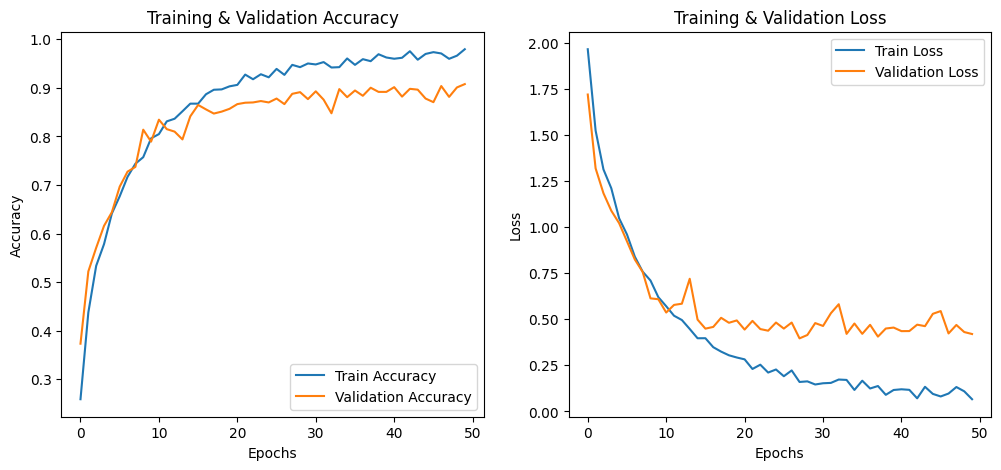

In [4]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

plot_training_history(history)
